In [1]:
# Evaluate and Predict using geo classification model

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.xception import preprocess_input
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

class GeoClassifier:
    def __init__(self, model_path: str, input_size: int = 299):
        """
        Initialize the classifier with a trained model.
        
        Args:
            model_path: Path to the saved Keras model
            input_size: Input size for the model (default: 299 for Xception)
        """
        self.input_size = input_size
        self.classes = [
            'buildings', 'forest', 'glacier',
            'mountain', 'sea', 'street'
        ]
        
        try:
            self.model = keras.models.load_model(model_path)
            print(f"Model loaded successfully from {model_path}")
        except Exception as e:
            raise Exception(f"Failed to load model from {model_path}: {str(e)}")
    
    def evaluate_test_set(self, test_dir: str, batch_size: int = 32) -> Tuple[float, float]:
        """
        Evaluate the model on a test dataset.
        
        Args:
            test_dir: Directory containing test images organized in class folders
            batch_size: Batch size for evaluation
            
        Returns:
            Tuple of (loss, accuracy)
        """
        if not os.path.exists(test_dir):
            raise FileNotFoundError(f"Test directory not found: {test_dir}")
            
        test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        test_ds = test_gen.flow_from_directory(
            test_dir,
            target_size=(self.input_size, self.input_size),
            batch_size=batch_size,
            shuffle=False
        )
        
        print("\nEvaluating model on test dataset...")
        loss, accuracy = self.model.evaluate(test_ds)
        print(f"\nTest Results:")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        
        return loss, accuracy
    
    def predict_image(self, image_path: str, display: bool = True) -> Dict[str, float]:
        """
        Predict the class of a single image.
        
        Args:
            image_path: Path to the image file
            display: Whether to display the image with predictions
            
        Returns:
            Dictionary of class probabilities
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
            
        # Load and preprocess image
        try:
            img = load_img(image_path, target_size=(self.input_size, self.input_size))
            x = np.array(img)
            X = np.array([x])
            X = preprocess_input(X)
        except Exception as e:
            raise Exception(f"Error processing image {image_path}: {str(e)}")
            
        # Make prediction
        pred = self.model.predict(X, verbose=0)
        
        # Convert to probabilities
        probabilities = tf.nn.softmax(pred[0]).numpy()
        
        # Create results dictionary
        results = dict(zip(self.classes, probabilities))
        
        # Sort by probability
        results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
        
        if display:
            self._display_prediction(img, results)
            
        return results
    
    def predict_batch(self, image_dir: str, batch_size: int = 32) -> List[Dict[str, float]]:
        """
        Predict classes for all images in a directory.
        
        Args:
            image_dir: Directory containing images
            batch_size: Batch size for predictions
            
        Returns:
            List of dictionaries containing class probabilities for each image
        """
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory not found: {image_dir}")
            
        # Create data generator for prediction
        pred_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
        pred_ds = pred_gen.flow_from_directory(
            image_dir,
            target_size=(self.input_size, self.input_size),
            batch_size=batch_size,
            shuffle=False
        )
        
        # Make predictions
        predictions = self.model.predict(pred_ds)
        
        # Convert to probabilities
        probabilities = tf.nn.softmax(predictions).numpy()
        
        # Create list of results
        results = []
        for pred in probabilities:
            results.append(dict(zip(self.classes, pred)))
            
        return results
    
    def _display_prediction(self, img, results: Dict[str, float]):
        """Display the image and prediction results."""
        plt.figure(figsize=(10, 5))
        
        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Input Image')
        
        # Display predictions
        plt.subplot(1, 2, 2)
        classes = list(results.keys())
        probs = list(results.values())
        
        y_pos = np.arange(len(classes))
        plt.barh(y_pos, probs)
        plt.yticks(y_pos, classes)
        plt.xlabel('Probability')
        plt.title('Predictions')
        
        plt.tight_layout()
        plt.show()

def main():
    """Main function to demonstrate usage."""
    # Initialize classifier
    try:
        classifier = GeoClassifier('geo-model.keras')
        
        # Evaluate on test set
        test_loss, test_acc = classifier.evaluate_test_set(
            '../data/seg_test/seg_test'
        )
        
        # Example single image prediction
        image_path = '../data/seg_pred/seg_pred/10054.jpg'
        results = classifier.predict_image(image_path)
        
        print("\nPrediction Results:")
        for class_name, prob in results.items():
            print(f"{class_name}: {prob:.4f}")
        
        # Example batch prediction
        batch_results = classifier.predict_batch('../data/seg_pred')
        print(f"\nProcessed {len(batch_results)} images in batch mode")
        
    except Exception as e:
        print(f"Error: {str(e)}")

# if __name__ == "__main__":
#     main()


"""
Usage:

# Simple single image prediction
classifier = GeoClassifier('geo-model.keras')
results = classifier.predict_image('path/to/image.jpg')

# Batch processing
results = classifier.predict_batch('path/to/image/directory')

# Evaluation
loss, acc = classifier.evaluate_test_set('path/to/test/directory')

"""

2024-12-27 03:09:22.190322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 03:09:22.206363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735268962.223007    7613 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735268962.227801    7613 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 03:09:22.246754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

"\nUsage:\n\n# Simple single image prediction\nclassifier = GeoClassifier('geo-model.keras')\nresults = classifier.predict_image('path/to/image.jpg')\n\n# Batch processing\nresults = classifier.predict_batch('path/to/image/directory')\n\n# Evaluation\nloss, acc = classifier.evaluate_test_set('path/to/test/directory')\n\n"

In [2]:
classifier = GeoClassifier('geo-model.keras')

I0000 00:00:1735268994.403664    7613 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model loaded successfully from geo-model.keras


I0000 00:00:1735269093.338769    7823 service.cc:148] XLA service 0x7f82140037e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735269093.338798    7823 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-27 03:11:33.375704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735269093.691396    7823 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-27 03:11:34.807298: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1735269095.577101    

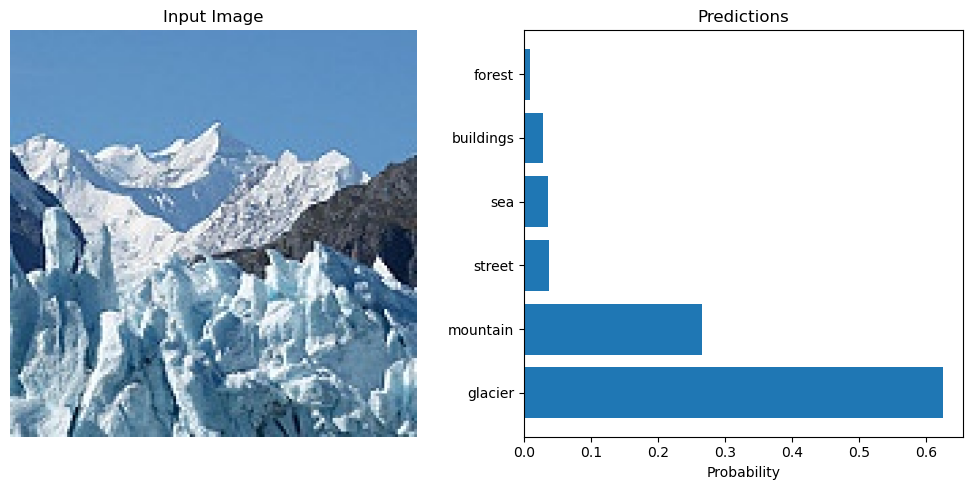

In [3]:
# Example single image prediction
image_path = '../data/seg_pred/seg_pred/10054.jpg'
results = classifier.predict_image(image_path)

In [4]:
results

{'glacier': np.float32(0.6242278),
 'mountain': np.float32(0.26605085),
 'street': np.float32(0.036834955),
 'sea': np.float32(0.03565502),
 'buildings': np.float32(0.0284684),
 'forest': np.float32(0.008762931)}

In [5]:
# Batch processing - 1 batch
results = classifier.predict_batch('../data/seg_pred/seg_pred')

Found 23 images belonging to 1 classes.


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-27 03:14:15.292714: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [6]:
results

[{'buildings': np.float32(0.03791363),
  'forest': np.float32(0.7678935),
  'glacier': np.float32(0.003796175),
  'mountain': np.float32(0.0033404345),
  'sea': np.float32(0.012493673),
  'street': np.float32(0.17456266)},
 {'buildings': np.float32(1.8017194e-05),
  'forest': np.float32(0.998178),
  'glacier': np.float32(0.00011033891),
  'mountain': np.float32(9.5249874e-05),
  'sea': np.float32(0.0013822617),
  'street': np.float32(0.00021617592)},
 {'buildings': np.float32(0.52572054),
  'forest': np.float32(0.026389988),
  'glacier': np.float32(0.0013533887),
  'mountain': np.float32(0.00075740076),
  'sea': np.float32(0.0019281023),
  'street': np.float32(0.4438506)},
 {'buildings': np.float32(0.028468352),
  'forest': np.float32(0.008762798),
  'glacier': np.float32(0.62422824),
  'mountain': np.float32(0.26605108),
  'sea': np.float32(0.035654403),
  'street': np.float32(0.036835123)},
 {'buildings': np.float32(0.04970317),
  'forest': np.float32(0.75075066),
  'glacier': np.flo